In [94]:
'''
Model default parameters
'''
import random
import numpy as np

M = 4 # Number of Spiking motifs
N = 20 # Number of input neurons
D = 71 # temporal depth of receptive field
T = 1000
nrn_fr = 15 # hz
pg_fr = 6 # hz
background_noise_fr = 10 # h
seed=41
np.random.seed(seed)

In [95]:
default_params = {
    'M':M,
    'N':N,
    'D':D,
    'T':T,
    'nrn_fr':nrn_fr,
    'pg_fr':pg_fr,
    'background_noise_fr':background_noise_fr,
    'seed':seed
}
scan_dict = {
    'M':[1,2,4,8,16,32,64,128],
    'N':[5,10,15,20,40,80],
    'D':[5,11,21,31,51,71,101],
    'T':[500,1000,1500],
    'nrn_fr':[5,10,15,20,25,35,50],
    'pg_fr':[4,5,8,10,15,20],
    'background_noise_fr':[0,2.5,5,7.5,10,12.5,15,20]
}

In [96]:
'''
Setup
'''

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys
np.set_printoptions(threshold=sys.maxsize)
disp_figs = True
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 101 colors (11 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])

In [108]:
import random
import numpy as np
import json
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from collections import Counter

def generate_synthetic_data(params):
    '''
    Synthetic Data Generation
    '''
    # Dense K: matrix of binary images of sizeNxDxM
    # Sparse K: set of (delay d, neuron a, and pg b)

    M,N,D,T,nrn_fr,pg_fr,background_noise_fr = params['M'], params['N'], params['D'], params['T'], params['nrn_fr'],params['pg_fr'],params['background_noise_fr'],    
    K_dense = np.random.randint(0,999,(N,D,M))
    K_dense[K_dense < nrn_fr] = 1
    K_dense[K_dense >= nrn_fr] = 0
    K_sparse = np.where(K_dense)
    K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)

    # dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
    # spare B: set of all times t and pg's b
    B_dense = np.random.randint(0,999,(M,T))
    B_dense[B_dense < pg_fr] = 1
    B_dense[B_dense >= pg_fr] = 0
    B_sparse = np.where(B_dense)
    B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

    # now to make the full raster plot keeping the labels in-tact
    # dense A: the layered binary images of all neuron spikes by PG ( N x T x M
    A_dense = np.zeros((N,T+D,M+1))
    A_dense[...,0] = np.random.randint(0,999,(N,T+D))
    A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
    for i in range(len(B_sparse[0])):
        t = B_sparse[1][i]
        b = B_sparse[0][i]
        A_dense[:, t:t+D, b] += K_dense[...,b-1]

    A_sparse = np.where(A_dense)
    A_dense = np.sum(A_dense,axis=2)
    A_dense[A_dense>1] = 1
    
    return A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse

def cluster_and_label_mapping(params, A_sparse, A_dense):
    '''
    Post-processing and clustering
    '''
    M,N,D,T,nrn_fr,pg_fr,background_noise_fr = params['M'], params['N'], params['D'], params['T'], params['nrn_fr'],params['pg_fr'],params['background_noise_fr'],

    # Windowing the data
    window_dim = (int(np.ceil(D/2)), N) # choosing a window to surround the spikes, this is a prediction but for now we will use the a priori depth D
    valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0]) # spikes closer to border will not be counted for simplicity
    A_trunc = (A_sparse[0][valid_spikes],A_sparse[1][valid_spikes].copy(),A_sparse[2][valid_spikes].copy()) # creating a new "A_sparse" with only valid spikes
    M_labels = A_sparse[2][valid_spikes]
    N_labels = A_sparse[0][valid_spikes]
    T_labels = A_sparse[1][valid_spikes]
    windows = np.zeros((len(T_labels), N, window_dim[0]*2)) # creating a matrix of all of the windows surrounding every spike in the matrix
    for i,window_time in enumerate(T_labels):
        windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]

    HDPs = []
    sim_mats = []
    # Set the cutoff value for clustering
    cutoff = 1

    # Get the cluster assignments for each spike based on the hierarchical clustering
    clusters = []
    for n in range(N):
        test = windows[N_labels==n]
        if len(test) > 1:
            x = np.zeros((len(test),len(test)))
            for i in range(test.shape[0]):
                for j in range(test.shape[0]):
                    x[i,j] = np.sum(test[i]*test[j])/ min(np.sum(test[i]),np.sum(test[j]))
            sim_mats.append(x)
            dissimilarity = 1 - x
            if not np.all(dissimilarity == 0):
                HDPs.append(linkage(dissimilarity, method='complete'))
                clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))
        elif len(test) == 1:
            clusters += [n*100]
        

    clusters= np.array(clusters)

    time_differences = []
    cluster_sq = {}
    for cluster in np.unique(clusters):
        time_differences.append(list(np.diff(A_trunc[1][clusters == cluster])))
        if str(list(np.diff(A_trunc[1][clusters == cluster]))) in cluster_sq.keys():
            cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] + [cluster]
        else: 
            cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = [cluster]

    ''' 
    This is the second round of clustering. Only patterns that repeat across multiple neurons are considered a motif. 
    with some help from chatgpt
    '''

    # Convert the list of lists to a set of tuples to remove duplicates
    unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

    # Convert the set of tuples back to a list of lists
    unique_sublists = [list(sublist) for sublist in unique_sublists_set]

    # Count the occurrences of each unique sublist in the original list
    sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

    # Print the unique sublists and their respective counts
    for sublist in unique_sublists:
        count = sublist_counts[tuple(sublist)]

    sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
    sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron

    ''' to visualize the clusters'''

    recovered_labels = np.zeros_like(clusters)
    for l, key in enumerate(sublist_keys_filt):
        for k in cluster_sq[str(key)]:
            recovered_labels[clusters == k] = l+1

    ''' to get the timings'''

    # Sort y according to x
    sorted_indices = np.argsort(A_trunc[1])
    sorted_x = A_trunc[1][sorted_indices]

    all_times = []
    all_labels = []
    for key in sublist_keys_filt:
        pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
        for i,k in enumerate(cluster_sq[str(key)]):
            pattern_repetition_labels[i][clusters==k] = 1
            pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
        pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
        all_labels.append(pattern_repetition_labels)

        sorted_y = pattern_repetition_labels[sorted_indices]
        pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
        all_times.append(pattern_times)
        
    '''
    Mapping Cluster Labels for Visualization
    '''
    labels_array_1 = recovered_labels
    labels_array_2 = A_trunc[2]

    # Get unique labels from both arrays
    unique_labels_1 = np.unique(labels_array_1)
    unique_labels_2 = np.unique(labels_array_2)

    # Create a cost matrix where each entry represents the cost of matching two labels
    cost_matrix = np.zeros((len(unique_labels_1), len(unique_labels_2)))

    for i, label_1 in enumerate(unique_labels_1):
        for j, label_2 in enumerate(unique_labels_2):
            common_elements = np.logical_and(labels_array_1 == label_1, labels_array_2 == label_2)
            cost_matrix[i, j] = -np.sum(common_elements)

    # Use the Hungarian algorithm to find the optimal mapping
    row_indices, col_indices = linear_sum_assignment(cost_matrix)

    # Create a dictionary to store the many-to-one mapping
    mapping_dict = {}

    # Populate the mapping dictionary with the optimal mapping
    for i, j in zip(row_indices, col_indices):
        label_1 = unique_labels_1[i]
        label_2 = unique_labels_2[j]

        if label_1 in mapping_dict:
            mapping_dict[label_1].append(label_2)
        else:
            mapping_dict[label_1] = [label_2]

    # Find unmatched labels from labels_array_1
    unmatched_labels_1 = np.setdiff1d(unique_labels_1, list(mapping_dict.keys()))

    # Handle unmatched labels by assigning them to the closest label in labels_array_2
    for label_1 in unmatched_labels_1:
        closest_label_2 = unique_labels_2[np.argmin(cost_matrix[label_1, :])]
        mapping_dict[label_1] = [closest_label_2]

    # Map the labels from labels_array_1 to labels_array_2 using the mapping dictionary
    # Use the get method with a default value of -1 for labels without a mapping
    mapped_labels = np.array([mapping_dict[label] for label in labels_array_1]).squeeze()
    
    return clusters, recovered_labels, all_times, mapped_labels, A_trunc

def calculate_performance(A_trunc, mapped_labels):
    # Calculating performance
    TP = 0
    TN = 0
    total_TP = 0
    total_TN = 0
    for m in range(M):
        TP += np.sum(((A_trunc[2]==m) & (mapped_labels==m)) == True)
        TN += np.sum(((A_trunc[2]!=m) & (mapped_labels!=m)) == True)
        total_TP += np.sum(A_trunc[2]==m)
        total_TN += np.sum(A_trunc[2]!=m)
        
    performance_result = {'TP':TP/total_TP, 'TN':TN/total_TN}
    return performance_result
        
        
def main():
    # Define the number of random samples you want to take
    num_samples = 10  # Adjust this based on your computational resources
    
    trials = 1 -1
    
    # List to hold the results
    results = []
    
    param_combinations = np.array(np.meshgrid(*scan_dict.values())).T.reshape(-1, len(scan_dict))
    num_iterations = len(param_combinations)
    
    # Generate random indices for sampling
    random_indices = random.sample(range(num_iterations), num_samples)
    
    # Iterate through parameter combinations
    for idx in tqdm(random_indices):
        for trial in range(0,trials+1):
            seed=trial
            np.random.seed(seed)
            params = {key: int(val) for key, val in zip(scan_dict.keys(), param_combinations[idx])}

            # Run your program here to generate performance results
            print("Params:", params) 
            A_dense, A_sparse, _, _, _, _ = generate_synthetic_data(params)
            clusters, _, _, mapped_labels, A_trunc = cluster_and_label_mapping(params, A_sparse, A_dense)
            performance_result = calculate_performance(A_trunc, mapped_labels)

            # Create a dictionary to store the result
            result = {
                'idc': idx,
                'trial':trial,
                **params,  # Unpack the parameters as separate columns
                **performance_result
            }
            
            print(performance_result)

            # Append the result to the list
            results.append(result)
    # Write the entire list of results to a JSON file
    with open('results.json', 'w') as results_file:
        json.dump(results, results_file, indent=4)
        
    return results
        
results = main()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\miles\AppData\Local\Temp\ipykernel_15768\1982539190.py:82: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  HDPs.append(linkage(dissimilarity, method='complete'))
C:\Users\miles\AppData\Local\Temp\ipykernel_15768\1982539190.py:83: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))


Params: {'M': 1, 'N': 80, 'D': 11, 'T': 500, 'nrn_fr': 15, 'pg_fr': 10, 'background_noise_fr': 20}


 10%|████████▎                                                                          | 1/10 [00:00<00:03,  2.32it/s]

{'TP': 0.9872935196950444, 'TN': 0.9957645065650148}
Params: {'M': 64, 'N': 15, 'D': 21, 'T': 1000, 'nrn_fr': 10, 'pg_fr': 20, 'background_noise_fr': 15}


 40%|█████████████████████████████████▏                                                 | 4/10 [00:23<00:31,  5.21s/it]

{'TP': 0.5773480662983426, 'TN': 0.7873305980355588}
Params: {'M': 4, 'N': 15, 'D': 31, 'T': 500, 'nrn_fr': 20, 'pg_fr': 10, 'background_noise_fr': 7}
{'TP': 0.7243589743589743, 'TN': 0.9149305555555556}
Params: {'M': 128, 'N': 5, 'D': 11, 'T': 500, 'nrn_fr': 5, 'pg_fr': 8, 'background_noise_fr': 2}
{'TP': 0.5, 'TN': 0.8190661478599222}
Params: {'M': 2, 'N': 10, 'D': 11, 'T': 1500, 'nrn_fr': 25, 'pg_fr': 4, 'background_noise_fr': 5}
{'TP': 0.8586956521739131, 'TN': 0.9528985507246377}
Params: {'M': 16, 'N': 15, 'D': 101, 'T': 500, 'nrn_fr': 10, 'pg_fr': 8, 'background_noise_fr': 7}


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:24<00:12,  3.01s/it]

{'TP': 0.007246376811594203, 'TN': 0.9983541803818301}
Params: {'M': 32, 'N': 40, 'D': 51, 'T': 1000, 'nrn_fr': 25, 'pg_fr': 5, 'background_noise_fr': 0}


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:05<00:18,  9.17s/it]

{'TP': 0.617906683480454, 'TN': 0.8506654024584335}
Params: {'M': 1, 'N': 15, 'D': 31, 'T': 500, 'nrn_fr': 50, 'pg_fr': 4, 'background_noise_fr': 20}
{'TP': 0.9856459330143541, 'TN': 0.9952153110047847}
Params: {'M': 8, 'N': 40, 'D': 51, 'T': 1000, 'nrn_fr': 15, 'pg_fr': 15, 'background_noise_fr': 15}


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.68s/it]

{'TP': 0.061710398445092324, 'TN': 0.978546867992226}
Params: {'M': 32, 'N': 20, 'D': 51, 'T': 500, 'nrn_fr': 5, 'pg_fr': 4, 'background_noise_fr': 12}
{'TP': 0.8627450980392157, 'TN': 0.8186356073211315}


In [21]:
import pandas as pd

In [122]:
with open('results.json', 'r') as json_file:
    results = json.load(json_file)

In [123]:
results

[{'idc': 319589,
  'trial': 0,
  'M': 1,
  'N': 80,
  'D': 11,
  'T': 500,
  'nrn_fr': 15,
  'pg_fr': 10,
  'background_noise_fr': 20,
  'TP': 0.9872935196950444,
  'TN': 0.9957645065650148},
 {'idc': 290774,
  'trial': 0,
  'M': 64,
  'N': 15,
  'D': 21,
  'T': 1000,
  'nrn_fr': 10,
  'pg_fr': 20,
  'background_noise_fr': 15,
  'TP': 0.5773480662983426,
  'TN': 0.7873305980355588},
 {'idc': 151358,
  'trial': 0,
  'M': 4,
  'N': 15,
  'D': 31,
  'T': 500,
  'nrn_fr': 20,
  'pg_fr': 10,
  'background_noise_fr': 7,
  'TP': 0.7243589743589743,
  'TN': 0.9149305555555556},
 {'idc': 56538,
  'trial': 0,
  'M': 128,
  'N': 5,
  'D': 11,
  'T': 500,
  'nrn_fr': 5,
  'pg_fr': 8,
  'background_noise_fr': 2,
  'TP': 0.5,
  'TN': 0.8190661478599222},
 {'idc': 89431,
  'trial': 0,
  'M': 2,
  'N': 10,
  'D': 11,
  'T': 1500,
  'nrn_fr': 25,
  'pg_fr': 4,
  'background_noise_fr': 5,
  'TP': 0.8586956521739131,
  'TN': 0.9528985507246377},
 {'idc': 142442,
  'trial': 0,
  'M': 16,
  'N': 15,
  'D':

In [124]:
df = pd.DataFrame(results)
df

,idc,trial,M,N,D,T,nrn_fr,pg_fr,background_noise_fr,TP,TN
0,319589,0,1,80,11,500,15,10,20,0.987294,0.995765
1,290774,0,64,15,21,1000,10,20,15,0.577348,0.787331
2,151358,0,4,15,31,500,20,10,7,0.724359,0.914931
3,56538,0,128,5,11,500,5,8,2,0.500000,0.819066
4,89431,0,2,10,11,1500,25,4,5,0.858696,0.952899
5,142442,0,16,15,101,500,10,8,7,0.007246,0.998354
6,11650,0,32,40,51,1000,25,5,0,0.617907,0.850665
7,302546,0,1,15,31,500,50,4,20,0.985646,0.995215
8,284806,0,8,40,51,1000,15,15,15,0.061710,0.978547
9,211905,0,32,20,51,500,5,4,12,0.862745,0.818636


In [125]:
df

,idc,trial,M,N,D,T,nrn_fr,pg_fr,background_noise_fr,TP,TN
0,319589,0,1,80,11,500,15,10,20,0.987294,0.995765
1,290774,0,64,15,21,1000,10,20,15,0.577348,0.787331
2,151358,0,4,15,31,500,20,10,7,0.724359,0.914931
3,56538,0,128,5,11,500,5,8,2,0.500000,0.819066
4,89431,0,2,10,11,1500,25,4,5,0.858696,0.952899
5,142442,0,16,15,101,500,10,8,7,0.007246,0.998354
6,11650,0,32,40,51,1000,25,5,0,0.617907,0.850665
7,302546,0,1,15,31,500,50,4,20,0.985646,0.995215
8,284806,0,8,40,51,1000,15,15,15,0.061710,0.978547
9,211905,0,32,20,51,500,5,4,12,0.862745,0.818636


In [126]:
# Calculate correlation coefficients
correlation_matrix = df.corr()

# Print correlation coefficients for TP and TN
print("Correlation Coefficients for TP:")
print(correlation_matrix['TP'])

print("\nCorrelation Coefficients for TN:")
print(correlation_matrix['TN'])

Correlation Coefficients for TP:
idc                    0.154399
trial                       NaN
M                     -0.178115
N                      0.159789
D                     -0.664431
T                     -0.052671
nrn_fr                 0.422884
pg_fr                 -0.411688
background_noise_fr    0.272546
TP                     1.000000
TN                    -0.093727
Name: TP, dtype: float64

Correlation Coefficients for TN:
idc                    0.316696
trial                       NaN
M                     -0.732589
N                      0.347730
D                      0.232696
T                     -0.062093
nrn_fr                 0.472592
pg_fr                 -0.196362
background_noise_fr    0.382742
TP                    -0.093727
TN                     1.000000
Name: TN, dtype: float64


In [111]:
import pandas as pd
# Group by all the parameter columns and calculate the mean for TP and TN
grouped = df.groupby('T').mean()
print(grouped)

                idc  trial          M          N          D     nrn_fr  \
T                                                                        
500   197396.333333    0.0  30.333333  25.000000  39.333333  17.500000   
1000  195743.333333    0.0  34.666667  31.666667  41.000000  16.666667   
1500   89431.000000    0.0   2.000000  10.000000  11.000000  25.000000   

          pg_fr  background_noise_fr        TP        TN  
T                                                         
500    7.333333            11.333333  0.677882  0.923661  
1000  13.333333            10.000000  0.418988  0.872181  
1500   4.000000             5.000000  0.858696  0.952899  


In [113]:
# Group by the relevant parameters and calculate mean values across trials
grouped = df.groupby(['M', 'N', 'D', 'T', 'nrn_fr', 'pg_fr', 'background_noise_fr']).agg({
    'TP': 'mean', 'TN': 'mean'
}).reset_index()
grouped

,M,N,D,T,nrn_fr,pg_fr,background_noise_fr,TP,TN
0,1,15,31,500,50,4,20,0.985646,0.995215
1,1,80,11,500,15,10,20,0.987294,0.995765
2,2,10,11,1500,25,4,5,0.858696,0.952899
3,4,15,31,500,20,10,7,0.724359,0.914931
4,8,40,51,1000,15,15,15,0.061710,0.978547
5,16,15,101,500,10,8,7,0.007246,0.998354
6,32,20,51,500,5,4,12,0.862745,0.818636
7,32,40,51,1000,25,5,0,0.617907,0.850665
8,64,15,21,1000,10,20,15,0.577348,0.787331
9,128,5,11,500,5,8,2,0.500000,0.819066


In [114]:
tp_stats = df.groupby(['M', 'N', 'D', 'T', 'nrn_fr', 'pg_fr', 'background_noise_fr'])['TP'].agg(['mean', 'median', 'std'])
tn_stats = df.groupby(['M', 'N', 'D', 'T', 'nrn_fr', 'pg_fr', 'background_noise_fr'])['TN'].agg(['mean', 'median', 'std'])


In [115]:
tp_stats

mean    median  std
M   N  D   T    nrn_fr pg_fr background_noise_fr                         
1   15 31  500  50     4     20                   0.985646  0.985646  NaN
    80 11  500  15     10    20                   0.987294  0.987294  NaN
2   10 11  1500 25     4     5                    0.858696  0.858696  NaN
4   15 31  500  20     10    7                    0.724359  0.724359  NaN
8   40 51  1000 15     15    15                   0.061710  0.061710  NaN
16  15 101 500  10     8     7                    0.007246  0.007246  NaN
32  20 51  500  5      4     12                   0.862745  0.862745  NaN
    40 51  1000 25     5     0                    0.617907  0.617907  NaN
64  15 21  1000 10     20    15                   0.577348  0.577348  NaN
128 5  11  500  5      8     2                    0.500000  0.500000  NaN

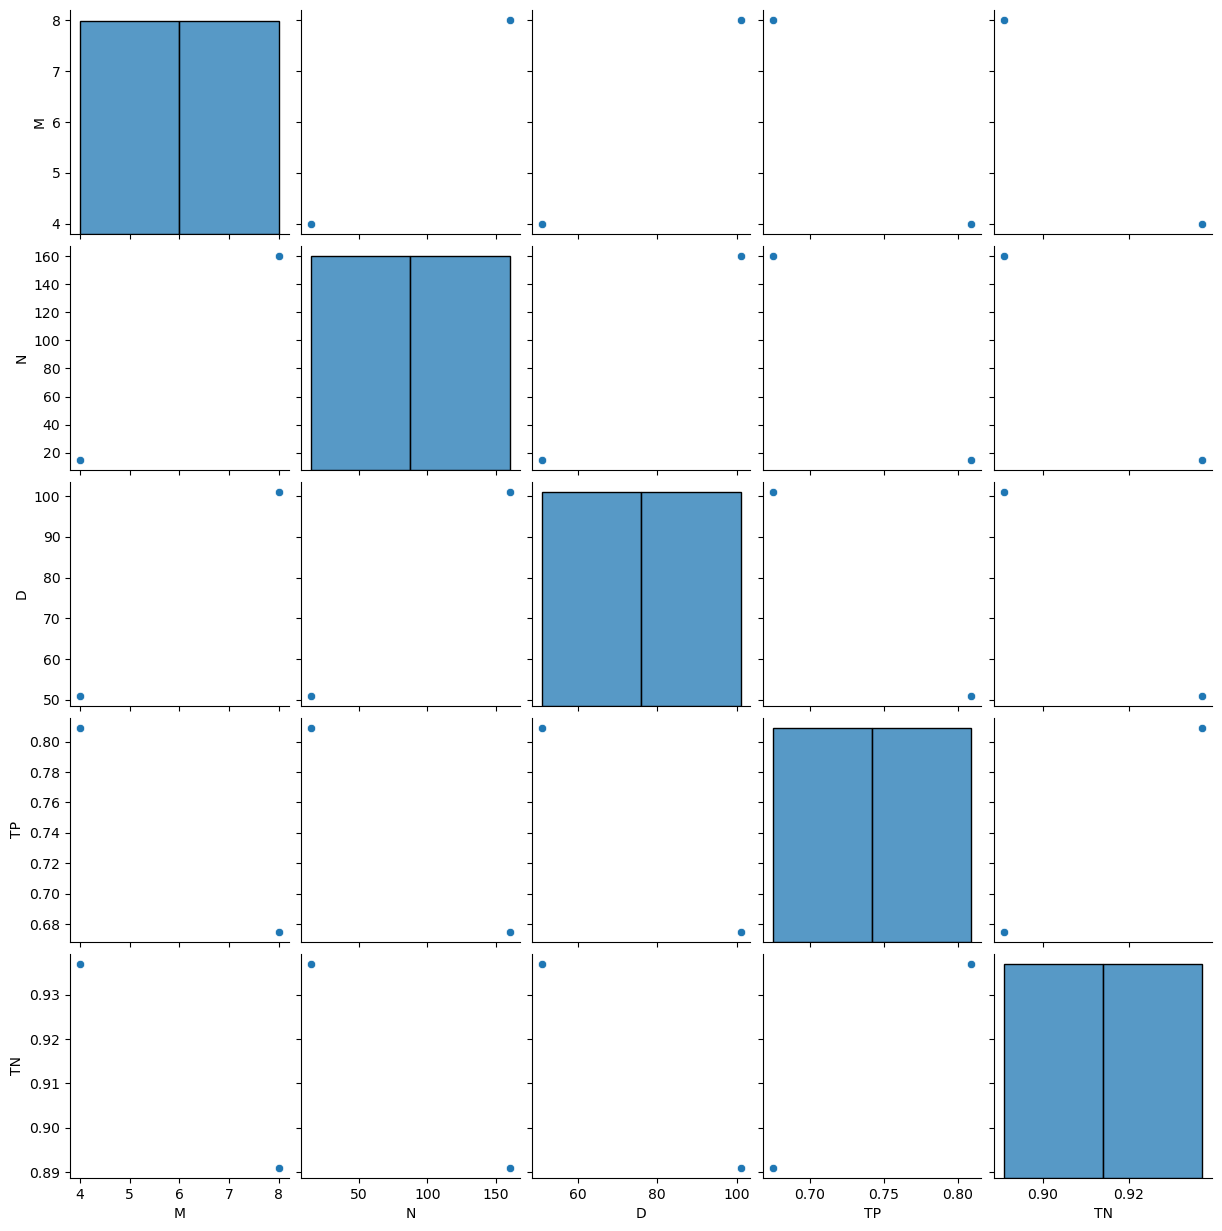

AttributeError: module 'seaborn' has no attribute 'parallel_coordinates'

<Figure size 1000x600 with 0 Axes>

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data into a list of dictionaries (similar to your 'results' list)
results = [
    {'idc': 659218, 'M': 4.0, 'N': 15.0, 'D': 51.0, 'TP': 0.809, 'TN': 0.937},
    {'idc': 541278, 'M': 8.0, 'N': 160.0, 'D': 101.0, 'TP': 0.675, 'TN': 0.891},
    # ... more data points ...
]

# Convert the list of dictionaries to a DataFrame for easier plotting
import pandas as pd
df = pd.DataFrame(results)

# Pair Plot (Scatter Plot Matrix)
sns.pairplot(df, vars=['M', 'N', 'D', 'TP', 'TN'])
plt.show()

# Parallel Coordinates Plot
plt.figure(figsize=(10, 6))
sns.parallel_coordinates(df, class_column='TP')
plt.show()

# Heatmap
plt.figure(figsize=(10, 6))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Bar Chart for Average TP and TN Rates by 'M'
plt.figure(figsize=(10, 6))
sns.barplot(x='M', y='TP', data=df)
plt.title('Average TP Rate by M')
plt.show()

# Violin Plot for TP and TN Rates across 'N'
plt.figure(figsize=(10, 6))
sns.violinplot(x='N', y='TP', data=df, inner='quartile')
plt.title('Distribution of TP Rates across N')
plt.show()

# Pairwise Density Plot for TP and TN Rates
sns.jointplot(x='TP', y='TN', data=df, kind='hex', color='blue')
plt.show()

# Interactive Filtering (using Plotly)
import plotly.express as px
fig = px.scatter(df, x='D', y='TP', color='M', size='TN', hover_name='idc')
fig.show()
